In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "high_z"
key = "lambda"
quantile = "0"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

10it [00:00, 97.55it/s]

23it [00:00, 103.61it/s]

36it [00:00, 108.55it/s]

48it [00:00, 111.43it/s]

60it [00:00, 112.66it/s]

70it [00:00, 97.81it/s] 

80it [00:00, 97.77it/s]

93it [00:00, 103.88it/s]

105it [00:00, 106.45it/s]

116it [00:01, 105.45it/s]

128it [00:01, 108.05it/s]

139it [00:01, 105.02it/s]

151it [00:01, 108.01it/s]

163it [00:01, 111.22it/s]

175it [00:01, 113.70it/s]

188it [00:01, 115.53it/s]

201it [00:01, 116.91it/s]

213it [00:01, 116.58it/s]

225it [00:02, 115.36it/s]

237it [00:02, 113.89it/s]

249it [00:02, 107.91it/s]

261it [00:02, 110.27it/s]

274it [00:02, 113.46it/s]

286it [00:02, 114.53it/s]

299it [00:02, 116.93it/s]

311it [00:02, 101.62it/s]

323it [00:02, 105.63it/s]

335it [00:03, 109.42it/s]

348it [00:03, 112.72it/s]

361it [00:03, 114.96it/s]

373it [00:03, 113.79it/s]

385it [00:03, 113.71it/s]

397it [00:03, 114.49it/s]

409it [00:03, 116.00it/s]

422it [00:03, 117.15it/s]

435it [00:03, 118.12it/s]

447it [00:03, 118.23it/s]

459it [00:04, 118.69it/s]

472it [00:04, 119.25it/s]

485it [00:04, 119.75it/s]

497it [00:04, 119.43it/s]

509it [00:04, 118.41it/s]

521it [00:04, 117.20it/s]

533it [00:04, 116.01it/s]

545it [00:04, 116.60it/s]

557it [00:04, 112.88it/s]

569it [00:05, 111.99it/s]

582it [00:05, 114.47it/s]

594it [00:05, 115.70it/s]

606it [00:05, 116.73it/s]

619it [00:05, 116.08it/s]

631it [00:05, 115.37it/s]

643it [00:05, 116.05it/s]

655it [00:05, 116.78it/s]

667it [00:05, 117.26it/s]

680it [00:05, 118.26it/s]

692it [00:06, 117.87it/s]

704it [00:06, 111.34it/s]

716it [00:06, 105.99it/s]

728it [00:06, 107.33it/s]

740it [00:06, 109.08it/s]

751it [00:06, 108.38it/s]

763it [00:06, 109.16it/s]

774it [00:06, 108.99it/s]

785it [00:06, 108.96it/s]

797it [00:07, 109.39it/s]

808it [00:07, 108.92it/s]

819it [00:07, 109.05it/s]

830it [00:07, 108.54it/s]

841it [00:07, 107.82it/s]

853it [00:07, 108.64it/s]

864it [00:07, 100.76it/s]

875it [00:07, 102.75it/s]

887it [00:07, 107.22it/s]

900it [00:08, 110.76it/s]

913it [00:08, 113.73it/s]

926it [00:08, 115.39it/s]

938it [00:08, 116.34it/s]

950it [00:08, 114.34it/s]

962it [00:08, 111.36it/s]

974it [00:08, 113.00it/s]

986it [00:08, 114.48it/s]

998it [00:08, 110.01it/s]

1010it [00:08, 110.40it/s]

1022it [00:09, 110.35it/s]

1034it [00:09, 110.94it/s]

1046it [00:09, 112.10it/s]

1058it [00:09, 112.35it/s]

1070it [00:09, 111.90it/s]

1082it [00:09, 111.64it/s]

1094it [00:09, 112.04it/s]

1106it [00:09, 111.53it/s]

1118it [00:09, 107.41it/s]

1130it [00:10, 109.56it/s]

1141it [00:10, 105.90it/s]

1152it [00:10, 107.04it/s]

1163it [00:10, 107.77it/s]

1174it [00:10, 108.41it/s]

1186it [00:10, 110.16it/s]

1198it [00:10, 110.90it/s]

1210it [00:10, 111.23it/s]

1222it [00:10, 111.74it/s]

1234it [00:11, 107.21it/s]

1245it [00:11, 105.28it/s]

1257it [00:11, 107.64it/s]

1269it [00:11, 110.54it/s]

1282it [00:11, 113.51it/s]

1294it [00:11, 115.09it/s]

1307it [00:11, 116.29it/s]

1319it [00:11, 115.66it/s]

1331it [00:11, 116.35it/s]

1343it [00:11, 117.18it/s]

1355it [00:12, 114.57it/s]

1367it [00:12, 114.14it/s]

1379it [00:12, 114.19it/s]

1391it [00:12, 105.64it/s]

1402it [00:12, 103.79it/s]

1413it [00:12, 101.12it/s]

1425it [00:12, 104.49it/s]

1437it [00:12, 107.70it/s]

1448it [00:12, 102.36it/s]

1460it [00:13, 103.74it/s]

1471it [00:13, 94.74it/s] 

1482it [00:13, 98.50it/s]

1494it [00:13, 100.24it/s]

1505it [00:13, 98.42it/s] 

1516it [00:13, 100.40it/s]

1527it [00:13, 90.72it/s] 

1537it [00:13, 92.79it/s]

1548it [00:14, 96.98it/s]

1560it [00:14, 100.60it/s]

1571it [00:14, 102.13it/s]

1582it [00:14, 93.06it/s] 

1594it [00:14, 99.37it/s]

1606it [00:14, 104.34it/s]

1617it [00:14, 94.96it/s] 

1629it [00:14, 101.04it/s]

1641it [00:14, 104.52it/s]

1653it [00:15, 107.81it/s]

1664it [00:15, 107.89it/s]

1676it [00:15, 111.13it/s]

1688it [00:15, 112.45it/s]

1700it [00:15, 114.34it/s]

1712it [00:15, 108.74it/s]

1724it [00:15, 111.66it/s]

1736it [00:15, 109.85it/s]

1749it [00:15, 112.95it/s]

1761it [00:15, 114.34it/s]

1773it [00:16, 115.64it/s]

1785it [00:16, 115.39it/s]

1797it [00:16, 115.98it/s]

1809it [00:16, 116.67it/s]

1822it [00:16, 117.64it/s]

1834it [00:16, 117.83it/s]

1846it [00:16, 117.09it/s]

1858it [00:16, 117.05it/s]

1870it [00:16, 115.54it/s]

1882it [00:17, 114.76it/s]

1894it [00:17, 102.73it/s]

1906it [00:17, 106.33it/s]

1918it [00:17, 109.50it/s]

1930it [00:17, 112.22it/s]

1942it [00:17, 110.37it/s]

1954it [00:17, 99.95it/s] 

1965it [00:17, 92.68it/s]

1977it [00:17, 98.74it/s]

1989it [00:18, 103.78it/s]

2001it [00:18, 108.16it/s]

2013it [00:18, 98.65it/s] 

2025it [00:18, 103.20it/s]

2036it [00:18, 96.66it/s] 

2048it [00:18, 101.77it/s]

2059it [00:18, 102.76it/s]

2071it [00:18, 107.11it/s]

2083it [00:18, 108.22it/s]

2095it [00:19, 109.60it/s]

2107it [00:19, 112.17it/s]

2119it [00:19, 114.13it/s]

2131it [00:19, 115.03it/s]

2143it [00:19, 116.08it/s]

2155it [00:19, 116.11it/s]

2167it [00:19, 117.17it/s]

2179it [00:19, 113.82it/s]

2191it [00:19, 115.29it/s]

2203it [00:20, 114.95it/s]

2215it [00:20, 116.12it/s]

2228it [00:20, 117.45it/s]

2240it [00:20, 117.64it/s]

2252it [00:20, 118.29it/s]

2264it [00:20, 118.61it/s]

2276it [00:20, 118.66it/s]

2288it [00:20, 112.93it/s]

2300it [00:20, 113.91it/s]

2312it [00:20, 115.54it/s]

2324it [00:21, 116.17it/s]

2336it [00:21, 117.15it/s]

2348it [00:21, 117.66it/s]

2361it [00:21, 118.42it/s]

2373it [00:21, 118.30it/s]

2385it [00:21, 118.30it/s]

2397it [00:21, 118.71it/s]

2409it [00:21, 118.88it/s]

2421it [00:21, 118.28it/s]

2434it [00:21, 119.09it/s]

2446it [00:22, 119.21it/s]

2458it [00:22, 117.82it/s]

2471it [00:22, 119.22it/s]

2483it [00:22, 119.30it/s]

2496it [00:22, 120.17it/s]

2509it [00:22, 119.80it/s]

2522it [00:22, 120.43it/s]

2535it [00:22, 120.67it/s]

2548it [00:22, 100.88it/s]

2559it [00:23, 102.76it/s]

2570it [00:23, 103.79it/s]

2583it [00:23, 108.38it/s]

2596it [00:23, 111.79it/s]

2609it [00:23, 114.24it/s]

2621it [00:23, 111.88it/s]

2633it [00:23, 112.91it/s]

2645it [00:23, 105.66it/s]

2657it [00:23, 109.27it/s]

2669it [00:24, 112.03it/s]

2682it [00:24, 114.40it/s]

2694it [00:24, 115.79it/s]

2706it [00:24, 116.70it/s]

2718it [00:24, 116.97it/s]

2730it [00:24, 117.83it/s]

2742it [00:24, 117.97it/s]

2754it [00:24, 118.41it/s]

2766it [00:24, 118.51it/s]

2779it [00:24, 119.15it/s]

2791it [00:25, 118.46it/s]

2803it [00:25, 118.28it/s]

2815it [00:25, 118.44it/s]

2828it [00:25, 118.75it/s]

2840it [00:25, 115.91it/s]

2852it [00:25, 115.81it/s]

2865it [00:25, 117.38it/s]

2878it [00:25, 118.26it/s]

2890it [00:25, 118.64it/s]

2903it [00:26, 119.17it/s]

2915it [00:26, 119.23it/s]

2927it [00:26, 112.96it/s]

2939it [00:26, 113.73it/s]

2951it [00:26, 114.11it/s]

2963it [00:26, 96.42it/s] 

2974it [00:26, 88.77it/s]

2984it [00:26, 90.88it/s]

2996it [00:26, 97.67it/s]

3008it [00:27, 102.84it/s]

3020it [00:27, 106.77it/s]

3032it [00:27, 110.27it/s]

3044it [00:27, 112.12it/s]

3056it [00:27, 113.73it/s]

3068it [00:27, 114.20it/s]

3080it [00:27, 114.48it/s]

3092it [00:27, 114.93it/s]

3104it [00:27, 116.27it/s]

3116it [00:28, 116.26it/s]

3128it [00:28, 116.61it/s]

3140it [00:28, 116.72it/s]

3152it [00:28, 116.45it/s]

3164it [00:28, 115.53it/s]

3176it [00:28, 115.64it/s]

3188it [00:28, 111.93it/s]

3200it [00:28, 113.90it/s]

3212it [00:28, 115.41it/s]

3224it [00:28, 114.54it/s]

3236it [00:29, 115.36it/s]

3248it [00:29, 115.65it/s]

3260it [00:29, 116.29it/s]

3272it [00:29, 117.03it/s]

3284it [00:29, 116.08it/s]

3296it [00:29, 113.99it/s]

3308it [00:29, 114.82it/s]

3320it [00:29, 106.35it/s]

3332it [00:29, 109.51it/s]

3344it [00:30, 112.03it/s]

3356it [00:30, 113.14it/s]

3368it [00:30, 114.13it/s]

3380it [00:30, 115.52it/s]

3392it [00:30, 116.50it/s]

3404it [00:30, 117.03it/s]

3416it [00:30, 101.87it/s]

3428it [00:30, 105.10it/s]

3440it [00:30, 107.80it/s]

3452it [00:30, 111.07it/s]

3464it [00:31, 113.29it/s]

3476it [00:31, 115.12it/s]

3489it [00:31, 116.90it/s]

3501it [00:31, 104.08it/s]

3512it [00:31, 102.05it/s]

3524it [00:31, 105.60it/s]

3535it [00:31, 100.16it/s]

3548it [00:31, 105.60it/s]

3560it [00:32, 108.91it/s]

3572it [00:32, 111.99it/s]

3584it [00:32, 111.91it/s]

3596it [00:32, 113.81it/s]

3608it [00:32, 114.80it/s]

3620it [00:32, 115.61it/s]

3632it [00:32, 112.46it/s]

3644it [00:32, 113.91it/s]

3656it [00:32, 113.97it/s]

3668it [00:32, 112.84it/s]

3680it [00:33, 114.10it/s]

3692it [00:33, 112.78it/s]

3704it [00:33, 109.71it/s]

3716it [00:33, 112.48it/s]

3728it [00:33, 114.36it/s]

3740it [00:33, 99.26it/s] 

3751it [00:33, 98.36it/s]

3763it [00:33, 103.66it/s]

3775it [00:33, 107.91it/s]

3787it [00:34, 110.76it/s]

3799it [00:34, 112.91it/s]

3812it [00:34, 115.42it/s]

3824it [00:34, 116.36it/s]

3836it [00:34, 116.22it/s]

3848it [00:34, 116.66it/s]

3860it [00:34, 116.97it/s]

3872it [00:34, 117.47it/s]

3884it [00:34, 116.45it/s]

3896it [00:34, 116.83it/s]

3908it [00:35, 116.90it/s]

3920it [00:35, 115.61it/s]

3932it [00:35, 116.39it/s]

3938it [00:35, 111.44it/s]


0it [00:00, ?it/s]

12it [00:00, 119.25it/s]

Number of empty sat catalogs is 7


25it [00:00, 120.27it/s]

37it [00:00, 119.95it/s]

49it [00:00, 118.43it/s]

62it [00:00, 121.13it/s]

75it [00:00, 123.34it/s]

88it [00:00, 123.95it/s]

101it [00:00, 122.72it/s]

113it [00:00, 119.60it/s]

126it [00:01, 121.65it/s]

139it [00:01, 122.71it/s]

152it [00:01, 123.73it/s]

165it [00:01, 124.11it/s]

178it [00:01, 125.01it/s]

191it [00:01, 125.08it/s]

204it [00:01, 125.67it/s]

217it [00:01, 126.24it/s]

230it [00:01, 126.02it/s]

243it [00:01, 123.00it/s]

256it [00:02, 124.00it/s]

269it [00:02, 124.66it/s]

282it [00:02, 124.86it/s]

295it [00:02, 125.36it/s]

308it [00:02, 125.71it/s]

321it [00:02, 125.77it/s]

334it [00:02, 125.74it/s]

347it [00:02, 125.47it/s]

360it [00:02, 107.53it/s]

372it [00:03, 109.10it/s]

385it [00:03, 112.76it/s]

397it [00:03, 102.97it/s]

409it [00:03, 106.22it/s]

421it [00:03, 108.27it/s]

433it [00:03, 110.20it/s]

445it [00:03, 97.40it/s] 

458it [00:03, 104.04it/s]

470it [00:03, 108.35it/s]

483it [00:04, 111.94it/s]

496it [00:04, 115.19it/s]

508it [00:04, 115.43it/s]

521it [00:04, 118.30it/s]

534it [00:04, 121.09it/s]

547it [00:04, 122.10it/s]

560it [00:04, 123.01it/s]

573it [00:04, 124.49it/s]

586it [00:04, 125.44it/s]

599it [00:05, 125.15it/s]

612it [00:05, 124.87it/s]

625it [00:05, 120.21it/s]

638it [00:05, 122.28it/s]

651it [00:05, 124.09it/s]

664it [00:05, 108.47it/s]

677it [00:05, 112.66it/s]

690it [00:05, 117.01it/s]

703it [00:05, 119.44it/s]

716it [00:06, 121.27it/s]

729it [00:06, 122.84it/s]

742it [00:06, 123.32it/s]

755it [00:06, 122.94it/s]

768it [00:06, 124.44it/s]

781it [00:06, 120.99it/s]

794it [00:06, 104.94it/s]

807it [00:06, 110.19it/s]

820it [00:06, 114.47it/s]

832it [00:07, 94.88it/s] 

844it [00:07, 99.84it/s]

857it [00:07, 107.13it/s]

870it [00:07, 112.68it/s]

883it [00:07, 116.01it/s]

896it [00:07, 119.49it/s]

909it [00:07, 121.47it/s]

922it [00:07, 123.37it/s]

935it [00:08, 82.27it/s] 

946it [00:08, 83.66it/s]

957it [00:08, 89.18it/s]

969it [00:08, 95.73it/s]

980it [00:08, 89.73it/s]

991it [00:08, 93.98it/s]

1004it [00:08, 101.92it/s]

1017it [00:08, 108.18it/s]

1030it [00:08, 112.80it/s]

1043it [00:09, 117.18it/s]

1056it [00:09, 120.16it/s]

1069it [00:09, 121.85it/s]

1082it [00:09, 117.19it/s]

1095it [00:09, 118.59it/s]

1107it [00:09, 118.74it/s]

1120it [00:09, 121.43it/s]

1133it [00:09, 123.14it/s]

1146it [00:09, 124.28it/s]

1159it [00:10, 114.65it/s]

1173it [00:10, 119.14it/s]

1186it [00:10, 111.41it/s]

1198it [00:10, 101.89it/s]

1210it [00:10, 105.63it/s]

1224it [00:10, 112.21it/s]

1238it [00:10, 117.29it/s]

1251it [00:10, 119.83it/s]

1264it [00:10, 122.13it/s]

1277it [00:11, 109.17it/s]

1289it [00:11, 101.35it/s]

1300it [00:11, 96.89it/s] 

1310it [00:11, 96.89it/s]

1324it [00:11, 105.08it/s]

1337it [00:11, 110.75it/s]

1351it [00:11, 116.11it/s]

1364it [00:11, 119.15it/s]

1377it [00:11, 122.13it/s]

1391it [00:12, 124.42it/s]

1405it [00:12, 126.22it/s]

1418it [00:12, 127.27it/s]

1431it [00:12, 126.27it/s]

1444it [00:12, 126.93it/s]

1458it [00:12, 127.81it/s]

1472it [00:12, 128.92it/s]

1485it [00:12, 127.91it/s]

1498it [00:12, 111.17it/s]

1510it [00:13, 111.79it/s]

1523it [00:13, 116.20it/s]

1536it [00:13, 119.82it/s]

1549it [00:13, 112.82it/s]

1562it [00:13, 116.74it/s]

1574it [00:13, 101.53it/s]

1588it [00:13, 108.81it/s]

1601it [00:13, 113.99it/s]

1613it [00:13, 112.13it/s]

1626it [00:14, 115.75it/s]

1639it [00:14, 118.48it/s]

1652it [00:14, 119.94it/s]

1665it [00:14, 120.83it/s]

1678it [00:14, 123.03it/s]

1691it [00:14, 124.06it/s]

1705it [00:14, 125.93it/s]

1718it [00:14, 126.75it/s]

1731it [00:14, 126.49it/s]

1744it [00:15, 127.08it/s]

1757it [00:15, 127.25it/s]

1770it [00:15, 127.87it/s]

1784it [00:15, 128.40it/s]

1797it [00:15, 128.72it/s]

1811it [00:15, 129.21it/s]

1824it [00:15, 112.36it/s]

1837it [00:15, 117.12it/s]

1851it [00:15, 120.60it/s]

1865it [00:16, 124.10it/s]

1878it [00:16, 112.10it/s]

1890it [00:16, 109.78it/s]

1902it [00:16, 109.47it/s]

1914it [00:16, 112.17it/s]

1928it [00:16, 117.20it/s]

1941it [00:16, 120.58it/s]

1955it [00:16, 123.26it/s]

1969it [00:16, 125.64it/s]

1982it [00:17, 126.15it/s]

1995it [00:17, 126.42it/s]

2008it [00:17, 127.37it/s]

2021it [00:17, 127.45it/s]

2035it [00:17, 128.40it/s]

2048it [00:17, 124.02it/s]

2061it [00:17, 125.51it/s]

2075it [00:17, 127.36it/s]

2088it [00:17, 127.45it/s]

2101it [00:17, 126.58it/s]

2114it [00:18, 125.85it/s]

2127it [00:18, 126.18it/s]

2140it [00:18, 119.72it/s]

2153it [00:18, 111.19it/s]

2165it [00:18, 104.91it/s]

2177it [00:18, 108.28it/s]

2189it [00:18, 111.17it/s]

2201it [00:18, 113.14it/s]

2213it [00:18, 114.18it/s]

2225it [00:19, 115.40it/s]

2237it [00:19, 116.57it/s]

2249it [00:19, 103.34it/s]

2262it [00:19, 108.12it/s]

2275it [00:19, 113.38it/s]

2289it [00:19, 118.23it/s]

2302it [00:19, 120.22it/s]

2315it [00:19, 122.72it/s]

2329it [00:19, 124.72it/s]

2342it [00:20, 125.98it/s]

2356it [00:20, 126.93it/s]

2369it [00:20, 126.68it/s]

2382it [00:20, 122.03it/s]

2396it [00:20, 124.66it/s]

2410it [00:20, 126.93it/s]

2423it [00:20, 127.29it/s]

2437it [00:20, 128.50it/s]

2450it [00:20, 110.33it/s]

2462it [00:21, 101.23it/s]

2474it [00:21, 104.54it/s]

2487it [00:21, 109.23it/s]

2499it [00:21, 111.63it/s]

2511it [00:21, 110.07it/s]

2523it [00:21, 108.91it/s]

2536it [00:21, 112.91it/s]

2549it [00:21, 115.36it/s]

2562it [00:21, 117.32it/s]

2575it [00:22, 117.87it/s]

2588it [00:22, 120.60it/s]

2601it [00:22, 121.63it/s]

2614it [00:22, 123.74it/s]

2627it [00:22, 125.38it/s]

2640it [00:22, 126.24it/s]

2653it [00:22, 126.62it/s]

2666it [00:22, 127.57it/s]

2679it [00:22, 127.79it/s]

2692it [00:22, 126.56it/s]

2705it [00:23, 127.40it/s]

2718it [00:23, 127.47it/s]

2731it [00:23, 128.09it/s]

2744it [00:23, 128.23it/s]

2757it [00:23, 119.77it/s]

2770it [00:23, 121.04it/s]

2783it [00:23, 119.30it/s]

2796it [00:23, 121.61it/s]

2809it [00:23, 122.89it/s]

2822it [00:24, 124.41it/s]

2835it [00:24, 124.44it/s]

2848it [00:24, 124.69it/s]

2861it [00:24, 121.66it/s]

2874it [00:24, 118.12it/s]

2886it [00:24, 118.64it/s]

2899it [00:24, 121.20it/s]

2912it [00:24, 121.80it/s]

2925it [00:24, 119.39it/s]

2938it [00:24, 117.62it/s]

2950it [00:25, 91.38it/s] 

2961it [00:25, 94.79it/s]

2974it [00:25, 101.52it/s]

2987it [00:25, 106.61it/s]

3000it [00:25, 111.01it/s]

3013it [00:25, 114.77it/s]

3025it [00:25, 111.58it/s]

3038it [00:25, 115.48it/s]

3051it [00:26, 118.02it/s]

3063it [00:26, 107.08it/s]

3075it [00:26, 100.76it/s]

3086it [00:26, 95.80it/s] 

3097it [00:26, 99.62it/s]

3110it [00:26, 106.76it/s]

3123it [00:26, 112.77it/s]

3136it [00:26, 116.21it/s]

3149it [00:26, 117.07it/s]

3162it [00:27, 119.10it/s]

3175it [00:27, 121.58it/s]

3188it [00:27, 123.86it/s]

3202it [00:27, 125.61it/s]

3215it [00:27, 126.57it/s]

3229it [00:27, 127.44it/s]

3242it [00:27, 127.96it/s]

3255it [00:27, 127.92it/s]

3268it [00:27, 127.98it/s]

3281it [00:27, 128.35it/s]

3295it [00:28, 128.96it/s]

3308it [00:28, 128.49it/s]

3321it [00:28, 128.34it/s]

3334it [00:28, 127.82it/s]

3347it [00:28, 108.41it/s]

3359it [00:28, 96.31it/s] 

3370it [00:28, 90.73it/s]

3380it [00:28, 88.67it/s]

3393it [00:29, 97.74it/s]

3407it [00:29, 105.71it/s]

3421it [00:29, 112.25it/s]

3434it [00:29, 116.93it/s]

3448it [00:29, 120.69it/s]

3462it [00:29, 123.85it/s]

3475it [00:29, 125.31it/s]

3488it [00:29, 126.51it/s]

3502it [00:29, 127.69it/s]

3515it [00:30, 127.67it/s]

3528it [00:30, 128.11it/s]

3541it [00:30, 121.01it/s]

3554it [00:30, 120.98it/s]

3568it [00:30, 123.48it/s]

3581it [00:30, 124.18it/s]

3594it [00:30, 125.55it/s]

3607it [00:30, 126.53it/s]

3620it [00:30, 127.33it/s]

3633it [00:30, 127.48it/s]

3646it [00:31, 127.60it/s]

3660it [00:31, 128.70it/s]

3673it [00:31, 128.67it/s]

3686it [00:31, 128.72it/s]

3699it [00:31, 127.80it/s]

3712it [00:31, 110.54it/s]

3725it [00:31, 114.24it/s]

3738it [00:31, 113.67it/s]

3750it [00:31, 110.59it/s]

3763it [00:32, 114.96it/s]

3776it [00:32, 117.69it/s]

3789it [00:32, 117.50it/s]

3801it [00:32, 103.92it/s]

3812it [00:32, 102.61it/s]

3823it [00:32, 95.15it/s] 

3835it [00:32, 99.70it/s]

3848it [00:32, 105.13it/s]

3861it [00:32, 111.09it/s]

3874it [00:33, 116.08it/s]

3887it [00:33, 119.52it/s]

3900it [00:33, 120.78it/s]

3914it [00:33, 123.58it/s]

3927it [00:33, 121.45it/s]

3938it [00:33, 117.18it/s]

Number of empty sat catalogs is 7


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

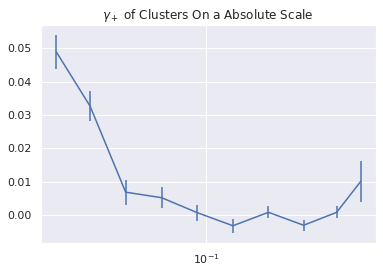

Aggregated xi:
[-20.6029 -26.1362  -8.8387 -10.4162  -2.2577  18.196   -5.9044  28.8463
  -5.3859  -6.8154]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1818.8741  -3096.394   -4400.1367  -5887.8841  -8682.3766 -10766.5455
 -11588.5719  -9130.0612  -4006.4091   -154.0383]
------------------------------------------------------------------------------
Aggregated npairs:
[ 421.  801. 1299. 2028. 3583. 5537. 7902. 9190. 7295.  681.]
------------------------------------------------------------------------------
Mean xi:
[-0.0489 -0.0326 -0.0068 -0.0051 -0.0006  0.0033 -0.0007  0.0031 -0.0007
 -0.01  ]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3204 -3.8657 -3.3873 -2.9033 -2.4232 -1.9445 -1.4665 -0.9935 -0.5492
 -0.2262]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

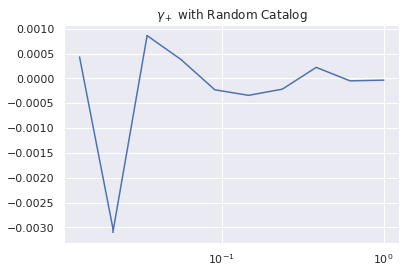

[ 4.3030e-04 -3.0562e-03  8.6036e-04  3.8116e-04 -2.2971e-04 -3.4155e-04
 -2.1683e-04  2.2134e-04 -5.0238e-05 -3.6069e-05]
[-6.8570e-06  4.8702e-05 -1.3710e-05 -6.0739e-06  3.6605e-06  5.4427e-06
  3.4552e-06 -3.5271e-06  8.0055e-07  5.7478e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

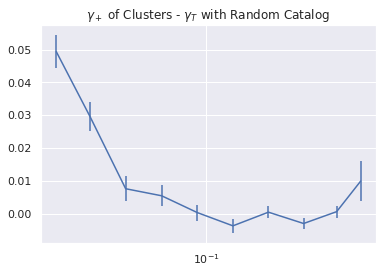

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

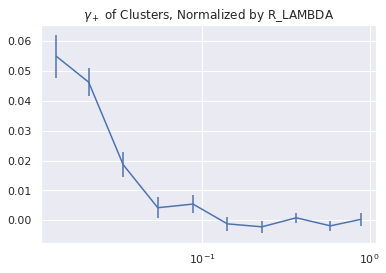

Aggregated xi:
[-10.2837 -25.9751 -17.9247  -6.2728 -13.4      5.0283  13.7804  -6.9483
  17.3895  -1.4504]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -805.427  -2166.4495 -3255.7536 -4344.4096 -6000.1249 -8116.1903
 -9239.5253 -8505.6289 -4982.6603  -615.0486]
------------------------------------------------------------------------------
Aggregated npairs:
[ 187.  561.  961. 1492. 2472. 4153. 6245. 8436. 9278. 5042.]
------------------------------------------------------------------------------
Mean xi:
[-0.055  -0.0463 -0.0187 -0.0042 -0.0054  0.0012  0.0022 -0.0008  0.0019
 -0.0003]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3071 -3.8618 -3.3879 -2.9118 -2.4272 -1.9543 -1.4795 -1.0083 -0.537
 -0.122 ]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)